## 2.2 筹码收益因子


In [2]:
import pandas as pd
import numpy as np
import sys

# 添加config路径
sys.path.append(r'C:\Users\ZHOU\Documents\2025CUHK\兴银\需要拷的数据\packages')
import config


import pickle
with open('frdata/stock_volume.pkl', 'rb') as f:
    stock_volume = pickle.load(f)
with open('frdata/stock_turnover_f.pkl', 'rb') as f:
    stock_turnover = pickle.load(f)
with open('frdata/stock_amount.pkl', 'rb') as f:
    stock_amount = pickle.load(f)
with open('frdata/stock_close.pkl', 'rb') as f:
    stock_close = pickle.load(f)
with open('frdata/stock_df.pkl', 'rb') as f:
    stock_df = pickle.load(f)
with open('frdata/stock_totalmv.pkl', 'rb') as f:
    stock_totalmv = pickle.load(f)

In [2]:
# vwap stock_amount 单位为万元，stock_volume 单位为手（1手=100股）
vwap = (stock_amount / stock_volume) * 100 
vwap.index

Index(['2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08', '2009-01-09',
       '2009-01-12', '2009-01-13', '2009-01-14', '2009-01-15', '2009-01-16',
       ...
       '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-07', '2025-04-08',
       '2025-04-09', '2025-04-10', '2025-04-11', '2025-04-14', '2025-04-15'],
      dtype='object', name='index', length=3954)

In [ ]:
window = 250
stock_turnover2 = stock_turnover.fillna(0)
survival_rate = 1 - stock_turnover2 / 100
holding_ret = pd.DataFrame(index=vwap.index, columns=vwap.columns)

for stock in vwap.columns:
    print(f"Processing {stock}...")
    vwap_vals = vwap[stock].values
    volume_vals = stock_volume[stock].values
    survival_vals = survival_rate[stock].values
    # 先计算累乘数组
    cum_survival = np.ones_like(survival_vals)
    cum_survival[1:] = np.cumprod(survival_vals[1:])
    result = np.full(len(vwap_vals), np.nan)
    for t in range(window-1, len(vwap_vals)):
        idx = np.arange(t-window+1, t+1)
        # 留存率 = cum_survival[t] / cum_survival[idx]
        # 对于最后一天（i==window-1），留存率为1
        survival_factors = cum_survival[t] / cum_survival[idx]
        survival_factors[-1] = 1.0  # 最后一天留存率为1
        rsd_volume = volume_vals[idx] * survival_factors
        total_rsd = np.sum(rsd_volume)
        if total_rsd > 0:
            weighted_cost = np.sum(vwap_vals[idx] * rsd_volume) / total_rsd
            # 筹码收益因子：当前价格相对加权成本的收益率
            result[t] = (vwap_vals[t] - weighted_cost) / weighted_cost
    holding_ret[stock] = result


In [ ]:
#holding_ret.to_pickle('holding_ret.pkl')

In [3]:
holding_ret = pd.read_pickle('holding_ret.pkl')

In [4]:
holding_ret.dropna(how='all')
holding_ret_copy = holding_ret.copy().dropna(how='all')

load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.0956 0.1284 -0.1521 0.1717 0.0541 -0.0510 0.1960 0.2255 0.0578   
波动率     0.0894 0.0562  0.0785 0.0754 0.0696  0.1061 0.1671 0.1247 0.1051   
最大回撤   0.0545 0.0375  0.1665 0.0643 0.0541  0.1031 0.1264 0.0941 0.1335   
夏普率     1.0696 2.2858 -1.9391 2.2777 0.7767 -0.4806 1.1729 1.8088 0.5506   
收益回撤比 1.7547 3.4203 -0.9140 2.6719 0.9994 -0.4947 1.5507 2.3962 0.4333   
半波       0.0488 0.0300  0.0503 0.0436 0.0435  0.0603 0.0892 0.0625 0.0567   
半夏普     1.9579 4.2778 -3.0235 3.9403 1.2422 -0.8456 2.1971 3.6082 1.0206   

              2024   2025   mean  
年化超额   -0.0332 0.3200 0.0921  
波动率      0.1982 0.1939 0.1149  
最大回撤    0.2155 0.0742 0.2155  
夏普率     -0.1678 1.6505 0.8012  
收益回撤比 -0.1542 4.3111 0.4271  
半波        0.1285 0.0684 0.

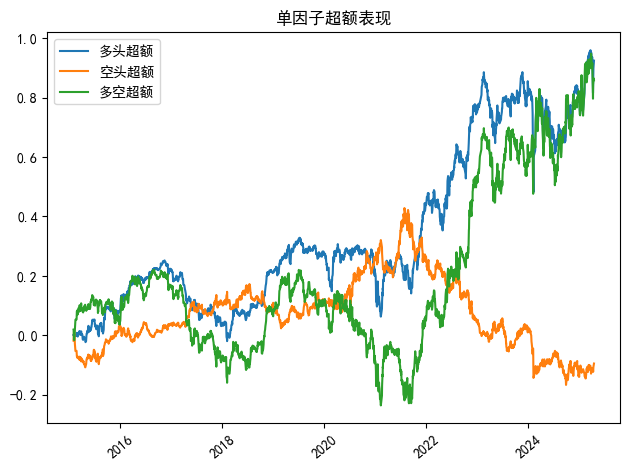

平均单边换手：0.504
年化交易成本:0.018 (未在超额中扣除)


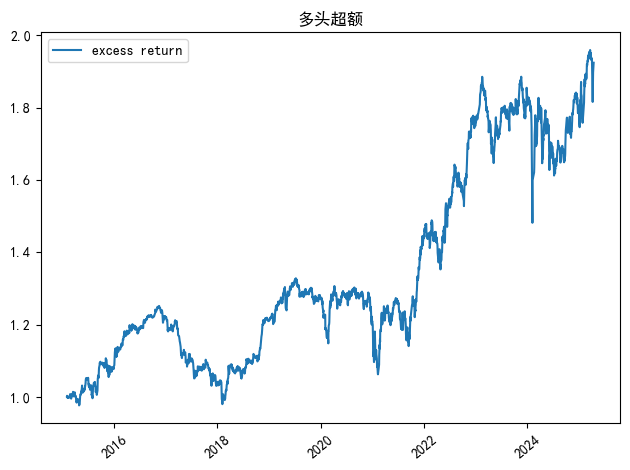

Rank IC: 3.68%
Rank ICIR: 0.25
t值: 2.72
年化收益率: 9.21%
年化波动率: 11.49%
信息比率: 0.80
最大回撤: 21.55%


In [ ]:
res=config.backtest_stand(-holding_ret_copy.loc['2015':],top=300,fre='month',stock_pool='888888')
# Rank IC
rank_ic = res['ic']['ic'].mean()
# Rank ICIR
rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
# t值
t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
perf = res['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")

### 筹码收益调整因子

In [5]:
# 对齐两个DataFrame
holding_ret_aligned = holding_ret_copy.align(stock_totalmv, join='inner', axis=1)[0]
holding_ret_aligned = holding_ret_aligned.align(stock_totalmv, join='inner', axis=0)[0]
print(holding_ret_aligned)
stock_totalmv_aligned = stock_totalmv.align(holding_ret_copy, join='inner', axis=1)[0]
stock_totalmv_aligned = stock_totalmv_aligned.align(holding_ret_copy, join='inner', axis=0)[0]
print(stock_totalmv_aligned)


            000001  000002  000004  000005  000006  000007  000008  000009  \
index                                                                        
2010-01-11     nan     nan     nan     nan     nan     nan     nan     nan   
2010-01-12     nan     nan     nan     nan     nan     nan     nan     nan   
2010-01-13     nan     nan     nan     nan     nan     nan     nan     nan   
2010-01-14     nan     nan     nan     nan     nan     nan     nan     nan   
2010-01-15     nan     nan     nan     nan     nan     nan     nan     nan   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-04-09 -0.0594 -0.0905 -0.2410     nan -0.1863     nan  0.0131 -0.1719   
2025-04-10 -0.0478 -0.0625 -0.1584     nan -0.1108     nan  0.0719 -0.1396   
2025-04-11 -0.0495 -0.0673 -0.1554     nan -0.0931     nan  0.0593 -0.1390   
2025-04-14 -0.0395 -0.0684 -0.1352     nan -0.0709     nan  0.0457 -0.1225   
2025-04-15 -0.0428 -0.0804 -0.0464     nan -0.0661     nan  0.00

In [6]:
# 计算市值加权均值
mkt_holding_ret = (holding_ret_aligned * stock_totalmv_aligned).sum(axis=1) / stock_totalmv_aligned.sum(axis=1)
mkt_holding_ret

index
2010-01-11    0.0000
2010-01-12    0.0000
2010-01-13    0.0000
2010-01-14    0.0001
2010-01-15    0.0000
               ...  
2025-04-09   -0.0651
2025-04-10   -0.0361
2025-04-11   -0.0341
2025-04-14   -0.0227
2025-04-15   -0.0234
Length: 3705, dtype: float64

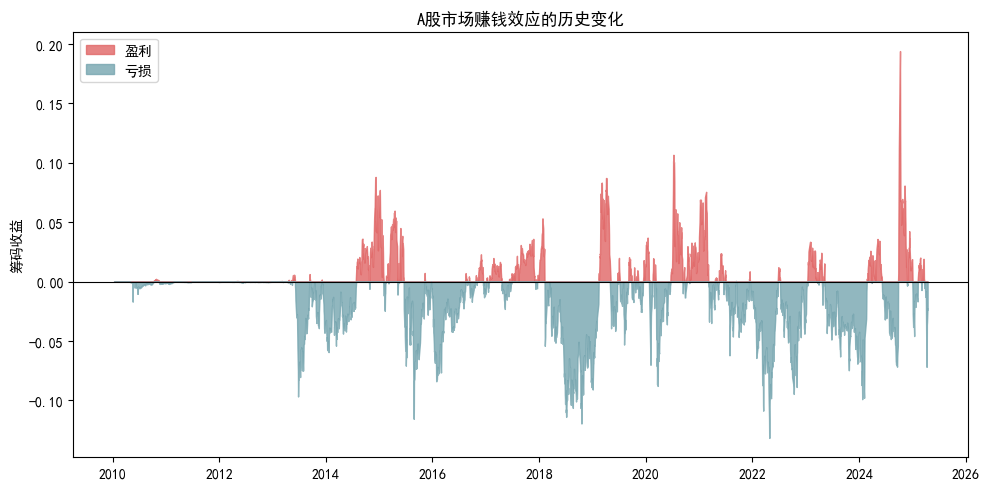

In [34]:
# 可视化mkt_holding_ret
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))

# 分别画正负部分
x = pd.to_datetime(mkt_holding_ret.index)
y = mkt_holding_ret.values

# 盈利部分
ax.fill_between(x, 0, np.where(y > 0, y, 0), color='#e06666', label='盈利', alpha=0.8)
# 亏损部分
ax.fill_between(x, 0, np.where(y < 0, y, 0), color='#76a5af', label='亏损', alpha=0.8)

ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('筹码收益')
ax.set_title('A股市场赚钱效应的历史变化')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
sign_mkt = np.sign(mkt_holding_ret).reindex(holding_ret_copy.index)
holding_ret_adj = holding_ret_copy.mul(sign_mkt, axis=0)
holding_ret_adj

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000022,000023,...,873726,873806,873833,920002,920008,920016,920019,920029,920060,920066,920082,920088,920098,920099,920106,920108,920111,920116,920118,920128
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2010-01-15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,0.0594,0.0905,0.2410,nan,0.1863,nan,-0.0131,0.1719,0.1951,0.1149,0.0943,0.1520,nan,0.1265,nan,-0.0461,0.2048,0.1811,nan,nan,...,0.1853,0.1376,0.0506,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2025-04-10,0.0478,0.0625,0.1584,nan,0.1108,nan,-0.0719,0.1396,0.1041,0.0707,0.0741,0.0515,nan,0.0577,nan,-0.0504,0.1113,0.1306,nan,nan,...,-0.0877,0.0512,-0.0500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2025-04-11,0.0495,0.0673,0.1554,nan,0.0931,nan,-0.0593,0.1390,0.0954,0.0720,0.0731,0.0156,nan,0.0366,nan,-0.0090,0.0971,0.1185,nan,nan,...,-0.0514,0.0589,-0.0150,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0305 0.1716 0.0300 0.1804 0.0829 0.0337 0.3788 0.2248 0.1959   
波动率     0.0882 0.0527 0.0669 0.0733 0.0624 0.1036 0.1455 0.1253 0.0968   
最大回撤   0.0553 0.0210 0.0436 0.0464 0.0541 0.0954 0.0855 0.0941 0.0626   
夏普率     0.3453 3.2580 0.4494 2.4629 1.3285 0.3255 2.6045 1.7934 2.0229   
收益回撤比 0.5515 8.1812 0.6888 3.8853 1.5307 0.3535 4.4324 2.3888 3.1274   
半波       0.0527 0.0262 0.0423 0.0410 0.0353 0.0597 0.0763 0.0623 0.0445   
半夏普     0.5779 6.5562 0.7098 4.3988 2.3446 0.5649 4.9663 3.6079 4.4007   

             2024   2025   mean  
年化超额   0.0678 0.2801 0.1524  
波动率     0.1882 0.1634 0.1060  
最大回撤   0.2155 0.0810 0.2155  
夏普率     0.3600 1.7136 1.4375  
收益回撤比 0.3144 3.4557 0.7072  
半波       0.1230 0.0612 0.0568  
半夏普     0.5510 4

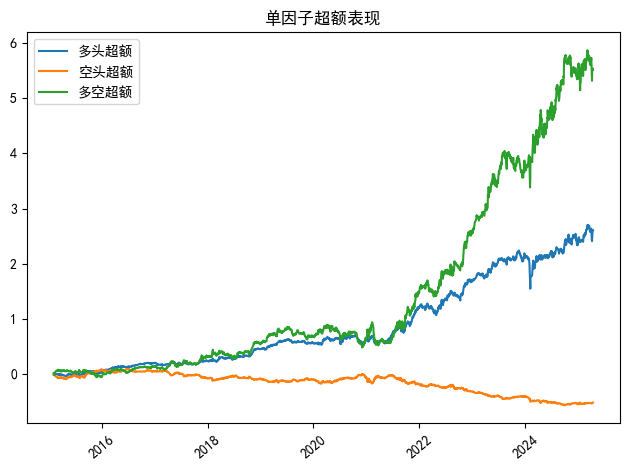

平均单边换手：0.591
年化交易成本:0.022 (未在超额中扣除)


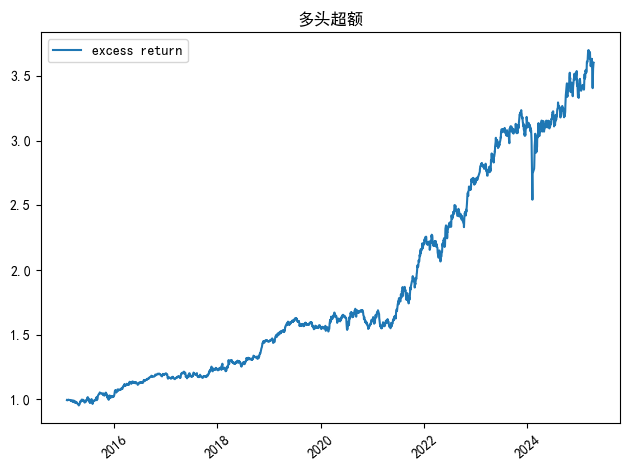

Rank IC: 5.04%
Rank ICIR: 0.34
t值: 3.82
年化收益率: 15.24%
年化波动率: 10.60%
信息比率: 1.44
最大回撤: 21.55%


In [39]:
res2=config.backtest_stand(holding_ret_adj.loc['2015':],top=300,fre='month',stock_pool='888888')
# Rank IC
rank_ic = res2['ic']['ic'].mean()
# Rank ICIR
rank_icir = res2['ic']['ic'].mean() / res2['ic']['ic'].std()
# t值
t_value = res2['ic']['ic'].mean() / (res2['ic']['ic'].std() / np.sqrt(res2['ic']['ic'].count()))
perf = res2['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")


## 3.1 ret20

In [8]:
ret20 = stock_df.rolling(20).mean()
sign_mkt2 = np.sign(mkt_holding_ret).reindex(ret20.index)
ret20_adj = ret20.mul(sign_mkt2, axis=0)
ret20_adj

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000022,000023,...,920019,920029,920060,920066,920082,920088,920098,920099,920106,920108,920111,920116,920118,920128,b1,b2,b3,b4,b5,b6
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,0.3470,0.2291,1.5301,nan,0.5499,0.6700,-0.2271,0.5791,0.7860,0.3019,0.1158,0.6284,1.1756,0.6456,nan,-0.4875,0.9632,0.8406,nan,nan,...,1.1063,nan,1.4223,0.8383,0.0251,0.8632,0.9393,0.4122,0.2993,0.5887,1.1233,1.1569,0.7289,1.1407,0.0032,0.0050,0.0037,0.0070,0.0015,0.0075
2025-04-10,0.4041,0.1367,1.4031,nan,0.3312,0.3082,-0.4678,0.4886,0.6691,0.2175,0.0642,0.1899,0.7333,0.4773,nan,-0.6026,0.7627,0.9091,nan,nan,...,0.7717,nan,1.1580,0.5699,0.1603,0.5591,0.5870,0.1048,0.1031,0.4563,0.9056,1.2323,0.4478,0.8016,0.0023,0.0040,0.0028,0.0059,0.0009,0.0063
2025-04-11,0.4045,0.1596,1.2928,nan,0.0628,0.1744,-0.4440,0.4213,0.5345,0.2561,0.0744,0.4381,0.0369,0.4202,nan,-0.3661,0.6210,0.6324,nan,nan,...,0.9113,nan,1.1779,0.8816,0.6056,0.7922,0.9745,0.3086,0.0251,1.2125,1.2452,1.1143,0.5357,1.0169,0.0019,0.0033,0.0023,0.0045,0.0007,0.0049


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1646 0.1900 -0.2017 0.0916 0.0230 -0.0409 0.1743 0.2005 0.2424   
波动率     0.1275 0.0813  0.1038 0.0961 0.0855  0.1276 0.1555 0.1494 0.1462   
最大回撤   0.1087 0.0712  0.2238 0.0740 0.0641  0.1711 0.1090 0.0896 0.0715   
夏普率     1.2903 2.3360 -1.9430 0.9526 0.2692 -0.3206 1.1207 1.3417 1.6574   
收益回撤比 1.5138 2.6676 -0.9013 1.2377 0.3587 -0.2392 1.5989 2.2368 3.3899   
半波       0.0813 0.0494  0.0759 0.0575 0.0538  0.0799 0.0850 0.0835 0.0776   
半夏普     2.0235 3.8474 -2.6586 1.5938 0.4274 -0.5124 2.0510 2.3996 3.1231   

              2024   2025   mean  
年化超额   -0.1398 0.0743 0.0707  
波动率      0.2852 0.2388 0.1452  
最大回撤    0.3799 0.1534 0.3799  
夏普率     -0.4900 0.3110 0.4873  
收益回撤比 -0.3679 0.4841 0.1862  
半波        0.1976 0.0769 0.

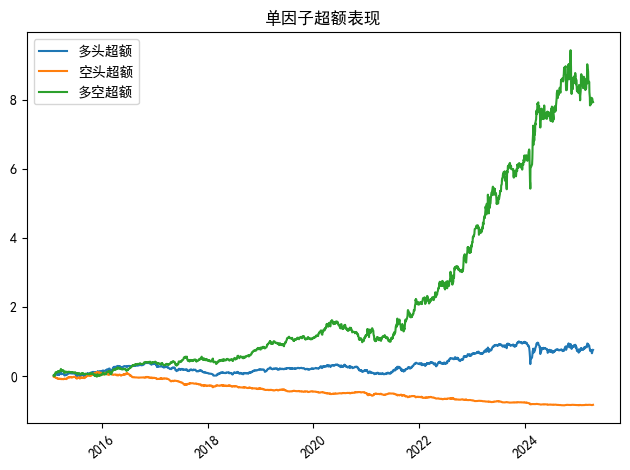

平均单边换手：0.809
年化交易成本:0.031 (未在超额中扣除)


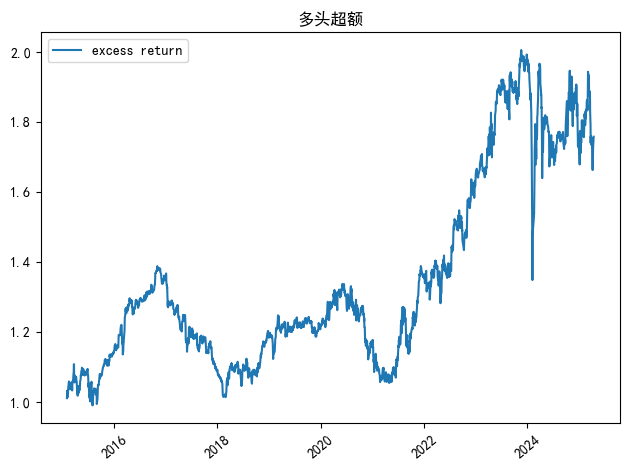

Rank IC: 4.41%
Rank ICIR: 0.29
t值: 3.23
年化收益率: 7.07%
年化波动率: 14.52%
信息比率: 0.49
最大回撤: 37.99%


In [20]:
res3=config.backtest_stand(ret20_adj.loc['2015':],top=300,fre='month',stock_pool='888888')
# Rank IC
rank_ic = res3['ic']['ic'].mean()
# Rank ICIR
rank_icir = res3['ic']['ic'].mean() / res3['ic']['ic'].std()
# t值
t_value = res3['ic']['ic'].mean() / (res3['ic']['ic'].std() / np.sqrt(res3['ic']['ic'].count()))
perf = res3['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")


## 3.2 筹码成本基准的增量贡献

In [2]:
ma_windows = [20, 40, 60, 120, 250]
ma_factors = {}

for N in ma_windows:
    ma = stock_close.rolling(window=N, min_periods=N).mean()
    ma_factor = (stock_close - ma) / ma
    ma_factors[N] = ma_factor

In [10]:
sign_mkt = np.sign(mkt_holding_ret).reindex(stock_close.index)

ma_factors_adj = {}
for N, ma_factor in ma_factors.items():
    ma_factor_adj = ma_factor.mul(sign_mkt, axis=0)
    ma_factors_adj[N] = ma_factor_adj

Backtesting MA20因子...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017    2018   2019    2020   2021   2022   2023  \
年化超额   0.1786 0.1090 -0.1807 -0.0154 0.0103 -0.0975 0.2054 0.0914 0.2478   
波动率     0.1129 0.0862  0.0893  0.0913 0.0887  0.1209 0.1484 0.1426 0.1368   
最大回撤   0.1004 0.0674  0.1985  0.1025 0.0776  0.1217 0.0920 0.0958 0.0596   
夏普率     1.5818 1.2639 -2.0225 -0.1686 0.1166 -0.8059 1.3841 0.6410 1.8110   
收益回撤比 1.7791 1.6160 -0.9100 -0.1503 0.1332 -0.8012 2.2336 0.9546 4.1543   
半波       0.0735 0.0511  0.0636  0.0565 0.0551  0.0752 0.0797 0.0843 0.0710   
半夏普     2.4291 2.1338 -2.8393 -0.2725 0.1878 -1.2958 2.5779 1.0846 3.4904   

              2024   2025   mean  
年化超额   -0.1887 0.0295 0.0354  
波动率      0.2861 0.2097 0.1376  
最大回撤    0.3769 0.1333 0.3769  
夏普率     -0.6595 0.1405 0.2575  
收益回撤比 -0.5006 0.2211 0.094

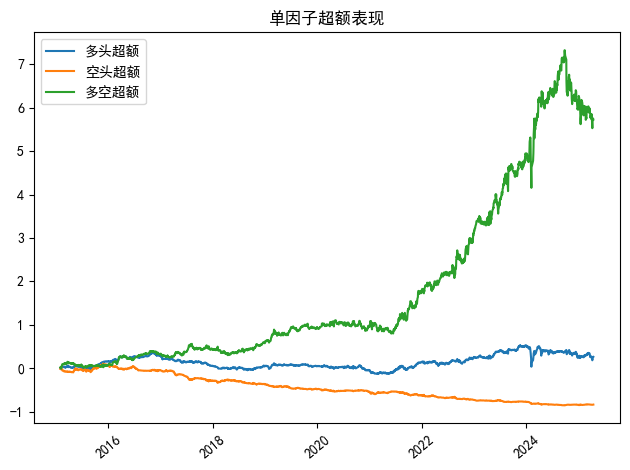

平均单边换手：0.807
年化交易成本:0.031 (未在超额中扣除)


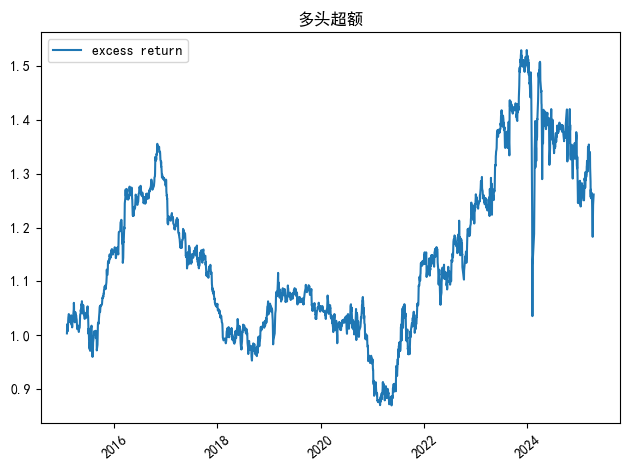

Backtesting MA40因子...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1928 0.1320 -0.1661 0.0719 0.0181 -0.0518 0.2676 0.2437 0.2960   
波动率     0.1206 0.0848  0.0996 0.0943 0.0866  0.1256 0.1611 0.1466 0.1410   
最大回撤   0.1063 0.0762  0.1805 0.0736 0.0692  0.1832 0.1092 0.0885 0.0636   
夏普率     1.5988 1.5574 -1.6676 0.7623 0.2091 -0.4122 1.6616 1.6620 2.0993   
收益回撤比 1.8143 1.7336 -0.9202 0.9773 0.2619 -0.2828 2.4501 2.7536 4.6540   
半波       0.0773 0.0519  0.0728 0.0570 0.0546  0.0766 0.0852 0.0797 0.0745   
半夏普     2.4934 2.5459 -2.2826 1.2622 0.3320 -0.6760 3.1403 3.0572 3.9714   

              2024   2025   mean  
年化超额   -0.1504 0.1075 0.0874  
波动率      0.2894 0.2411 0.1446  
最大回撤    0.3769 0.1525 0.3769  
夏普率     -0.5196 0.4460 0.6044  
收益回撤比 -0.3989 0.7048 0.2319  
半波  

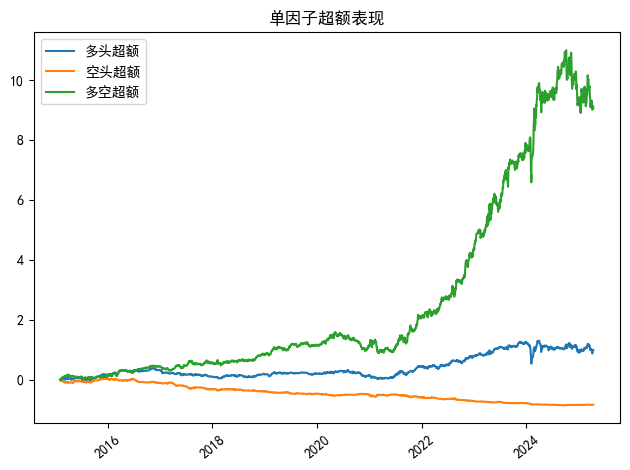

平均单边换手：0.747
年化交易成本:0.029 (未在超额中扣除)


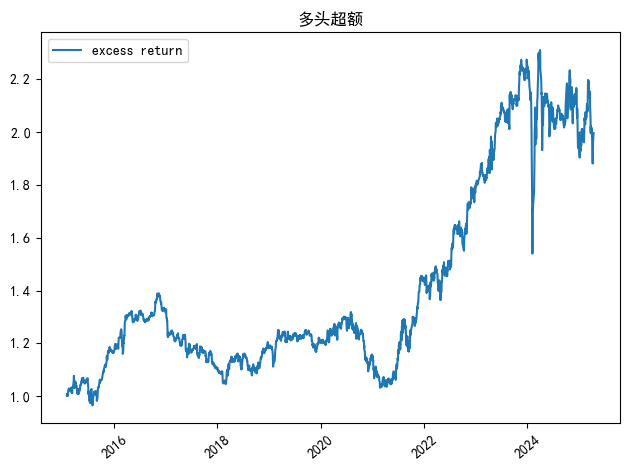

Backtesting MA60因子...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1645 0.1618 -0.1516 0.0783 0.0403 -0.0648 0.3085 0.2018 0.2564   
波动率     0.1239 0.0816  0.0999 0.0927 0.0863  0.1238 0.1666 0.1477 0.1444   
最大回撤   0.1135 0.0631  0.1672 0.0622 0.0701  0.2081 0.1163 0.1228 0.0672   
夏普率     1.3284 1.9839 -1.5175 0.8441 0.4673 -0.5233 1.8521 1.3665 1.7762   
收益回撤比 1.4500 2.5664 -0.9068 1.2587 0.5754 -0.3114 2.6520 1.6427 3.8149   
半波       0.0802 0.0479  0.0714 0.0558 0.0547  0.0782 0.0852 0.0763 0.0769   
半夏普     2.0512 3.3759 -2.1225 1.4025 0.7373 -0.8288 3.6194 2.6459 3.3342   

              2024   2025   mean  
年化超额   -0.0875 0.2095 0.1016  
波动率      0.2773 0.2404 0.1440  
最大回撤    0.3517 0.1324 0.3517  
夏普率     -0.3156 0.8713 0.7051  
收益回撤比 -0.2488 1.5817 0.2888  
半波  

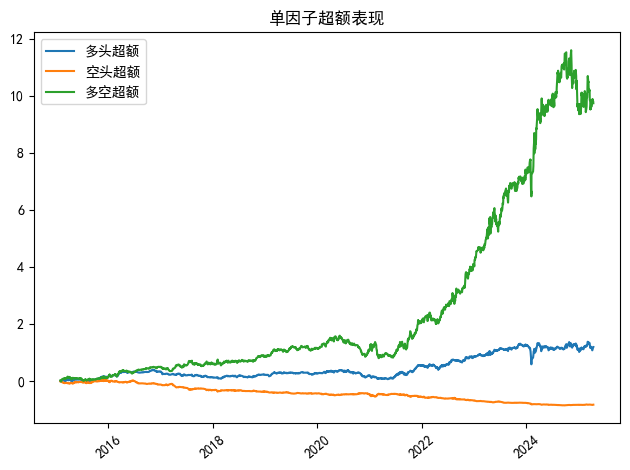

平均单边换手：0.676
年化交易成本:0.025 (未在超额中扣除)


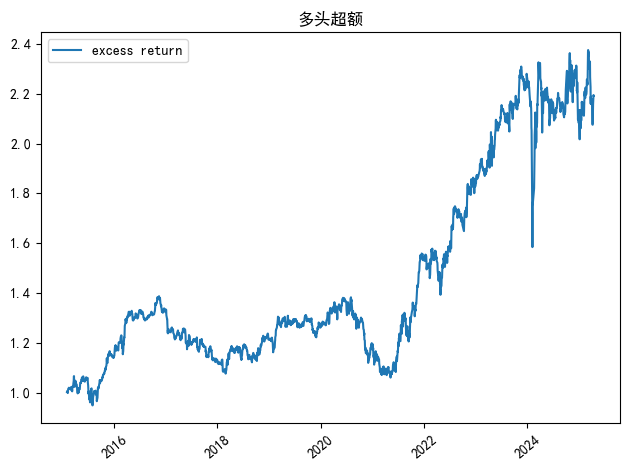

Backtesting MA120因子...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1267 0.1274 -0.1120 0.1123 0.0621 -0.0679 0.2153 0.2579 0.2676   
波动率     0.1094 0.0604  0.0857 0.0922 0.0824  0.1152 0.1673 0.1348 0.1484   
最大回撤   0.1019 0.0326  0.1358 0.0552 0.0504  0.2125 0.1345 0.1212 0.0626   
夏普率     1.1580 2.1074 -1.3077 1.2184 0.7543 -0.5888 1.2872 1.9131 1.8037   
收益回撤比 1.2432 3.9059 -0.8248 2.0329 1.2329 -0.3193 1.6006 2.1278 4.2773   
半波       0.0712 0.0345  0.0602 0.0550 0.0518  0.0750 0.0871 0.0685 0.0774   
半夏普     1.7803 3.6906 -1.8597 2.0405 1.1983 -0.9052 2.4732 3.7639 3.4593   

             2024   2025   mean  
年化超额   0.0552 0.1555 0.1091  
波动率     0.2462 0.2425 0.1350  
最大回撤   0.2744 0.1335 0.2744  
夏普率     0.2242 0.6411 0.8085  
收益回撤比 0.2012 1.1645 0.3976  
半波       

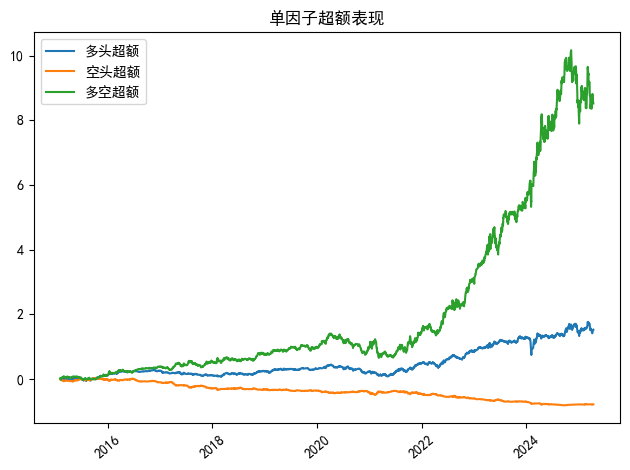

平均单边换手：0.554
年化交易成本:0.02 (未在超额中扣除)


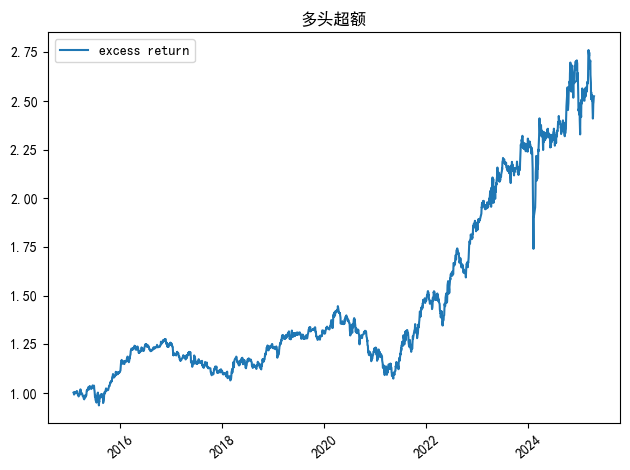

Backtesting MA250因子...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1089 0.1415 -0.0138 0.1958 0.0523 -0.0337 0.1955 0.2197 0.1252   
波动率     0.0935 0.0445  0.0683 0.0907 0.0786  0.1134 0.1626 0.1278 0.1303   
最大回撤   0.0889 0.0209  0.0728 0.0645 0.0507  0.2038 0.1387 0.1307 0.0762   
夏普率     1.1645 3.1776 -0.2018 2.1599 0.6653 -0.2973 1.2026 1.7194 0.9603   
收益回撤比 1.2249 6.7718 -0.1893 3.0363 1.0319 -0.1654 1.4100 1.6803 1.6434   
半波       0.0596 0.0215  0.0461 0.0543 0.0495  0.0712 0.0883 0.0656 0.0668   
半夏普     1.8269 6.5864 -0.2990 3.6092 1.0555 -0.4735 2.2154 3.3482 1.8741   

             2024   2025   mean  
年化超额   0.0015 0.0736 0.0970  
波动率     0.2184 0.2114 0.1218  
最大回撤   0.2894 0.1082 0.2894  
夏普率     0.0067 0.3484 0.7962  
收益回撤比 0.0050 0.6804 0.3350  
半波       

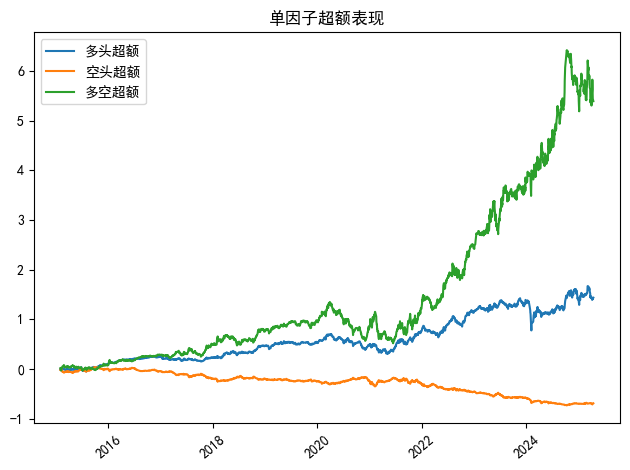

平均单边换手：0.449
年化交易成本:0.016 (未在超额中扣除)


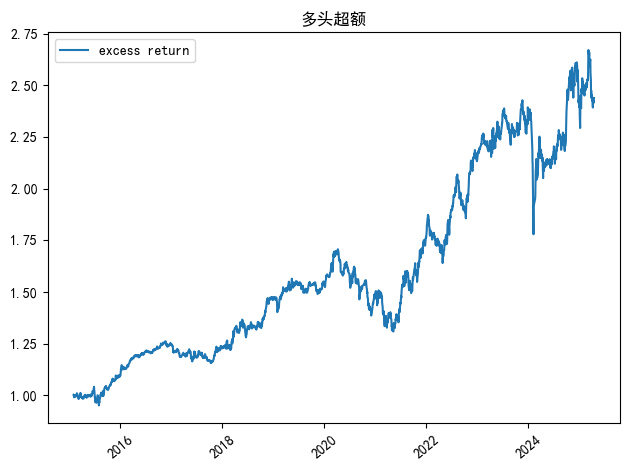

In [11]:
results = {}
for N, ma_factor_adj in ma_factors_adj.items():
    print(f"Backtesting MA{N}因子...")
    res = config.backtest_stand(ma_factor_adj.loc['2015':], top=300, fre='month', stock_pool='888888')
    results[N] = res

## 4.1 市场赚钱效应的切分阈值

Backtesting threshold=-6.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022    2023  \
年化超额   0.0956 0.0957 0.0687 0.1570 0.0325 0.1417 0.0002 0.1372 -0.0245   
波动率     0.0788 0.0493 0.0624 0.0787 0.0711 0.1110 0.1439 0.1415  0.1037   
最大回撤   0.0514 0.0454 0.0442 0.0523 0.0661 0.0609 0.1304 0.0967  0.1107   
夏普率     1.2137 1.9433 1.1015 1.9951 0.4577 1.2758 0.0017 0.9697 -0.2365   
收益回撤比 1.8589 2.1081 1.5534 3.0023 0.4920 2.3263 0.0019 1.4193 -0.2214   
半波       0.0479 0.0266 0.0338 0.0421 0.0418 0.0678 0.0884 0.0785  0.0604   
半夏普     1.9958 3.6038 2.0310 3.7294 0.7793 2.0882 0.0028 1.7483 -0.4057   

              2024   2025   mean  
年化超额   -0.0960 0.1528 0.0692  
波动率      0.1857 0.1146 0.1037  
最大回撤    0.2487 0.0492 0.2487  
夏普率     -0.5171 1.3336 0.6671  
收益回撤比 -0.3862 3.1048 0.2782  
半

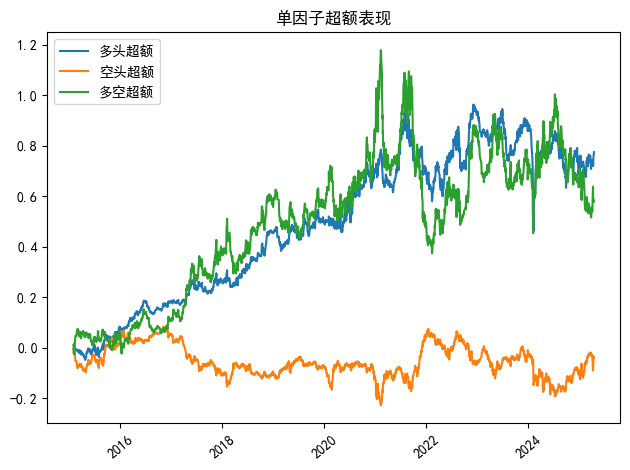

平均单边换手：0.586
年化交易成本:0.022 (未在超额中扣除)


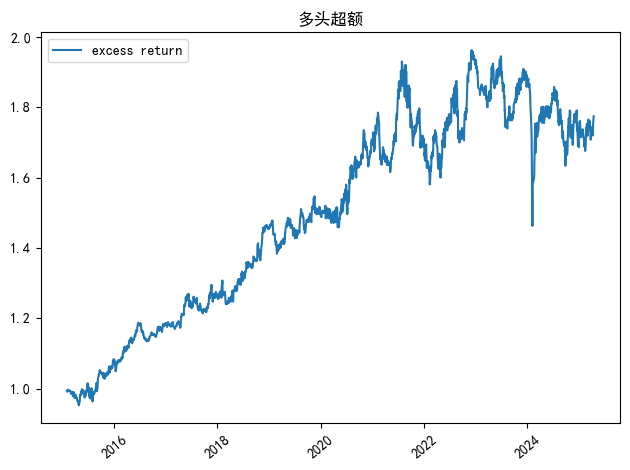

Rank IC: -0.12%
Rank ICIR: -0.01
t值: -0.09
年化收益率: 6.92%
年化波动率: 10.37%
信息比率: 0.67
最大回撤: 24.87%
Backtesting threshold=-5.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022    2023  \
年化超额   0.0956 0.0957 0.0687 0.1829 0.0325 0.1633 0.0002 0.1372 -0.0245   
波动率     0.0788 0.0493 0.0624 0.0767 0.0711 0.1052 0.1439 0.1415  0.1037   
最大回撤   0.0514 0.0454 0.0442 0.0523 0.0661 0.0609 0.1304 0.0967  0.1107   
夏普率     1.2137 1.9433 1.1015 2.3855 0.4577 1.5532 0.0017 0.9697 -0.2365   
收益回撤比 1.8589 2.1081 1.5534 3.4983 0.4920 2.6820 0.0019 1.4193 -0.2214   
半波       0.0479 0.0266 0.0338 0.0421 0.0418 0.0617 0.0884 0.0785  0.0604   
半夏普     1.9958 3.6038 2.0310 4.3405 0.7793 2.6462 0.0028 1.7483 -0.4057   

              2024   2025   mean  
年化超额   -0.0960 0.1528 0.0735  
波动率      0.1857 0.1146 0.1030  


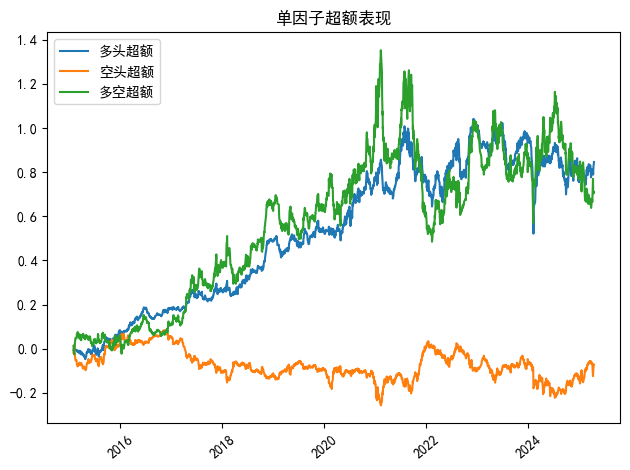

平均单边换手：0.58
年化交易成本:0.021 (未在超额中扣除)


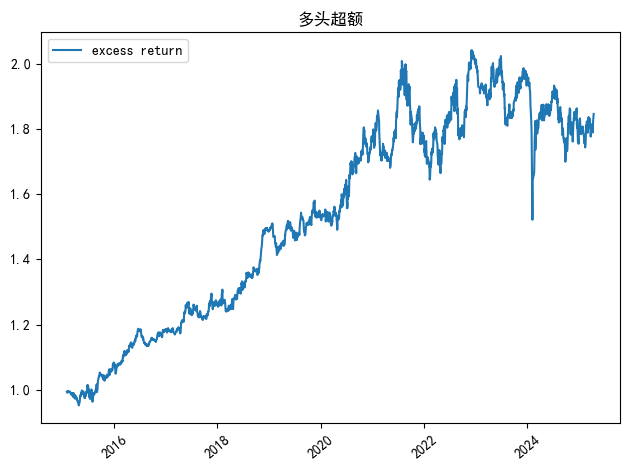

Rank IC: 0.14%
Rank ICIR: 0.01
t值: 0.10
年化收益率: 7.35%
年化波动率: 10.30%
信息比率: 0.71
最大回撤: 24.87%
Backtesting threshold=-4.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022    2023  \
年化超额   0.0956 0.0957 0.0687 0.1549 0.0325 0.1633 0.0447 0.0585 -0.0460   
波动率     0.0788 0.0493 0.0624 0.0726 0.0711 0.1052 0.1353 0.1466  0.1043   
最大回撤   0.0514 0.0454 0.0442 0.0523 0.0661 0.0609 0.1081 0.1441  0.1107   
夏普率     1.2137 1.9433 1.1015 2.1350 0.4577 1.5532 0.3305 0.3993 -0.4412   
收益回撤比 1.8589 2.1081 1.5534 2.9634 0.4920 2.6820 0.4140 0.4061 -0.4156   
半波       0.0479 0.0266 0.0338 0.0402 0.0418 0.0617 0.0797 0.0817  0.0571   
半夏普     1.9958 3.6038 2.0310 3.8536 0.7793 2.6462 0.5615 0.7164 -0.8067   

              2024   2025   mean  
年化超额   -0.0641 0.1528 0.0688  
波动率      0.1849 0.1146 0.1023  
最大回

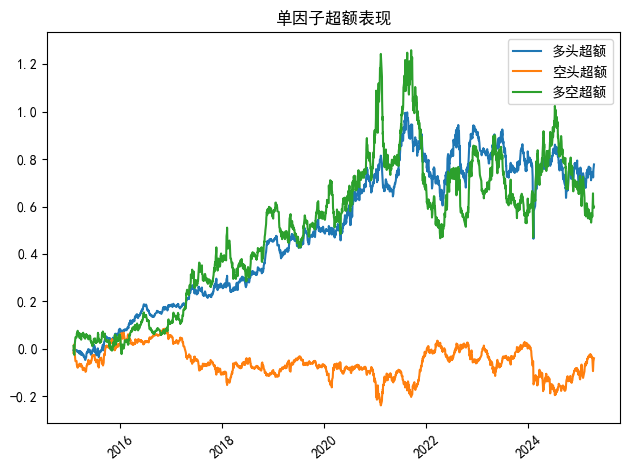

平均单边换手：0.578
年化交易成本:0.021 (未在超额中扣除)


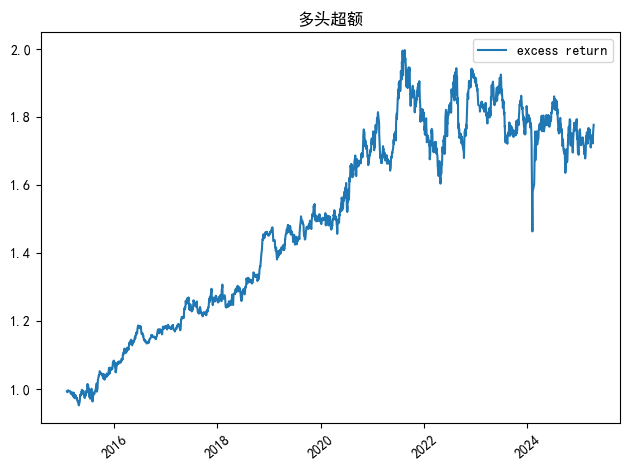

Rank IC: 0.46%
Rank ICIR: 0.03
t值: 0.33
年化收益率: 6.88%
年化波动率: 10.23%
信息比率: 0.67
最大回撤: 21.55%
Backtesting threshold=-3.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0956 0.0957 0.0687 0.1163 0.1215 0.1633 0.1427 0.0590 0.0655   
波动率     0.0788 0.0493 0.0624 0.0680 0.0706 0.1052 0.1367 0.1465 0.0929   
最大回撤   0.0514 0.0454 0.0442 0.0720 0.0462 0.0609 0.0985 0.1441 0.0715   
夏普率     1.2137 1.9433 1.1015 1.7091 1.7219 1.5532 1.0438 0.4026 0.7047   
收益回撤比 1.8589 2.1081 1.5534 1.6147 2.6321 2.6820 1.4494 0.4091 0.9151   
半波       0.0479 0.0266 0.0338 0.0387 0.0396 0.0617 0.0788 0.0816 0.0456   
半夏普     1.9958 3.6038 2.0310 3.0061 3.0724 2.6462 1.8113 0.7228 1.4352   

             2024   2025   mean  
年化超额   0.0388 0.1524 0.1018  
波动率     0.1815 0.1145 0.1006  
最大回撤   0.2155 

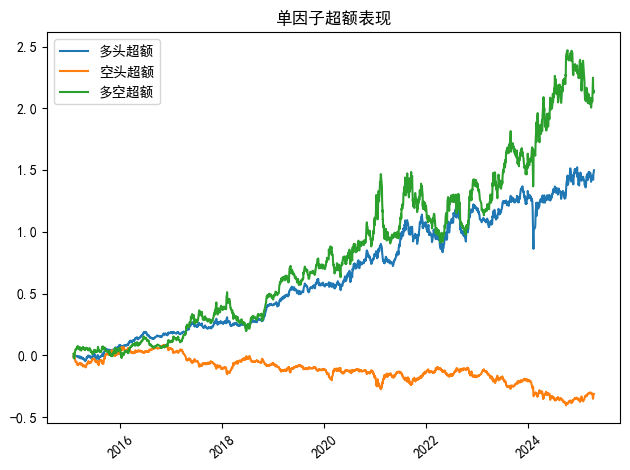

平均单边换手：0.57
年化交易成本:0.021 (未在超额中扣除)


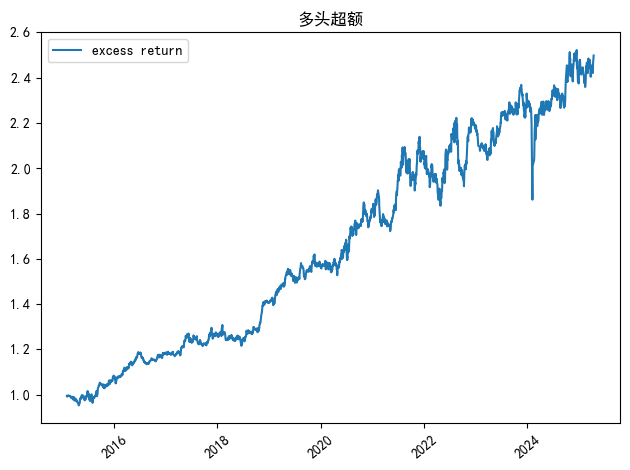

Rank IC: 1.90%
Rank ICIR: 0.12
t值: 1.37
年化收益率: 10.18%
年化波动率: 10.06%
信息比率: 1.01
最大回撤: 21.55%
Backtesting threshold=-2.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0305 0.1652 0.0726 0.1163 0.1563 0.1773 0.2570 0.1542 0.1716   
波动率     0.0882 0.0531 0.0625 0.0680 0.0690 0.1062 0.1443 0.1294 0.0924   
最大回撤   0.0553 0.0210 0.0447 0.0720 0.0462 0.0681 0.0985 0.1156 0.0626   
夏普率     0.3453 3.1103 1.1618 1.7091 2.2638 1.6694 1.7818 1.1916 1.8572   
收益回撤比 0.5515 7.8764 1.6245 1.6147 3.3840 2.6039 2.6105 1.3343 2.7401   
半波       0.0527 0.0257 0.0339 0.0387 0.0376 0.0593 0.0791 0.0657 0.0444   
半夏普     0.5779 6.4235 2.1376 3.0062 4.1609 2.9901 3.2502 2.3469 3.8621   

             2024   2025   mean  
年化超额   0.0617 0.1524 0.1377  
波动率     0.1841 0.1145 0.1011  
最大回撤   0.2155

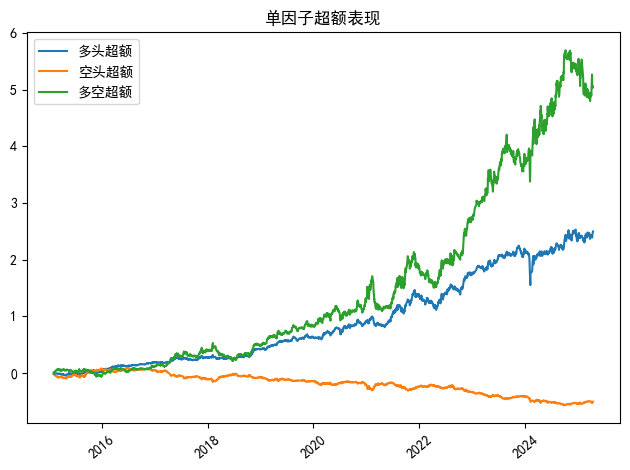

平均单边换手：0.577
年化交易成本:0.021 (未在超额中扣除)


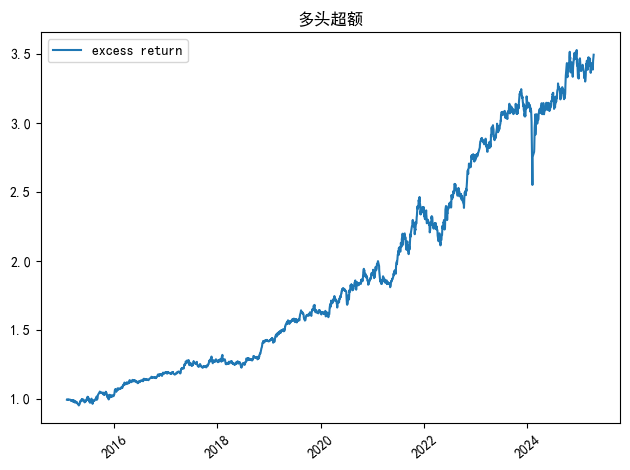

Rank IC: 3.69%
Rank ICIR: 0.25
t值: 2.72
年化收益率: 13.77%
年化波动率: 10.11%
信息比率: 1.36
最大回撤: 21.55%
Backtesting threshold=-1.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0305 0.1935 0.0731 0.1800 0.1385 0.1228 0.3839 0.1809 0.1716   
波动率     0.0882 0.0532 0.0624 0.0733 0.0667 0.1055 0.1443 0.1291 0.0924   
最大回撤   0.0553 0.0210 0.0447 0.0469 0.0462 0.0811 0.0873 0.1111 0.0626   
夏普率     0.3453 3.6397 1.1709 2.4564 2.0775 1.1633 2.6614 1.4013 1.8572   
收益回撤比 0.5515 9.2216 1.6370 3.8424 3.0005 1.5132 4.3980 1.6279 2.7401   
半波       0.0527 0.0257 0.0340 0.0410 0.0365 0.0598 0.0757 0.0651 0.0444   
半夏普     0.5779 7.5144 2.1530 4.3867 3.7931 2.0544 5.0724 2.7782 3.8621   

             2024   2025   mean  
年化超额   0.0617 0.0287 0.1423  
波动率     0.1841 0.1647 0.1058  
最大回撤   0.2155

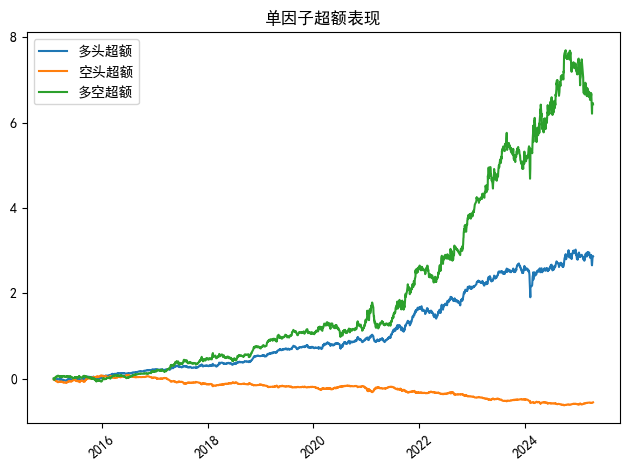

平均单边换手：0.598
年化交易成本:0.022 (未在超额中扣除)


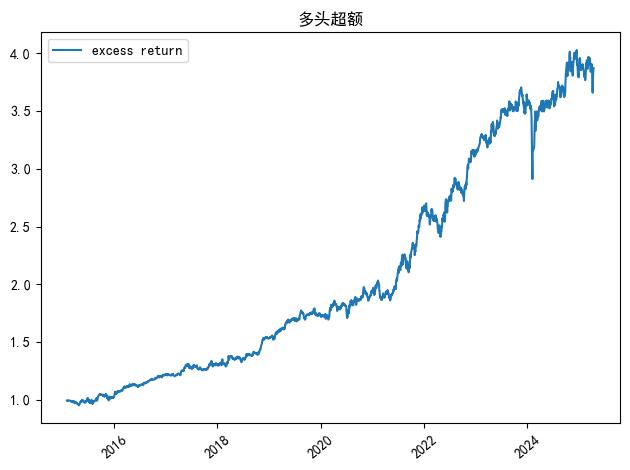

Rank IC: 4.82%
Rank ICIR: 0.33
t值: 3.64
年化收益率: 14.23%
年化波动率: 10.58%
信息比率: 1.34
最大回撤: 21.55%
Backtesting threshold=0.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0305 0.1716 0.0300 0.1804 0.0829 0.0337 0.3788 0.2248 0.1959   
波动率     0.0882 0.0527 0.0669 0.0733 0.0624 0.1036 0.1455 0.1253 0.0968   
最大回撤   0.0553 0.0210 0.0436 0.0464 0.0541 0.0954 0.0855 0.0941 0.0626   
夏普率     0.3453 3.2580 0.4494 2.4629 1.3285 0.3255 2.6045 1.7934 2.0229   
收益回撤比 0.5515 8.1812 0.6888 3.8853 1.5307 0.3535 4.4324 2.3888 3.1274   
半波       0.0527 0.0262 0.0423 0.0410 0.0353 0.0597 0.0763 0.0623 0.0445   
半夏普     0.5779 6.5562 0.7098 4.3988 2.3446 0.5649 4.9663 3.6079 4.4007   

             2024   2025   mean  
年化超额   0.0678 0.2801 0.1524  
波动率     0.1882 0.1634 0.1060  
最大回撤   0.2155 

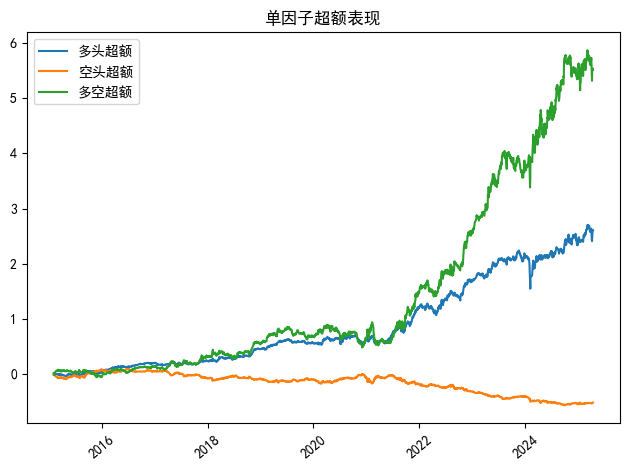

平均单边换手：0.591
年化交易成本:0.022 (未在超额中扣除)


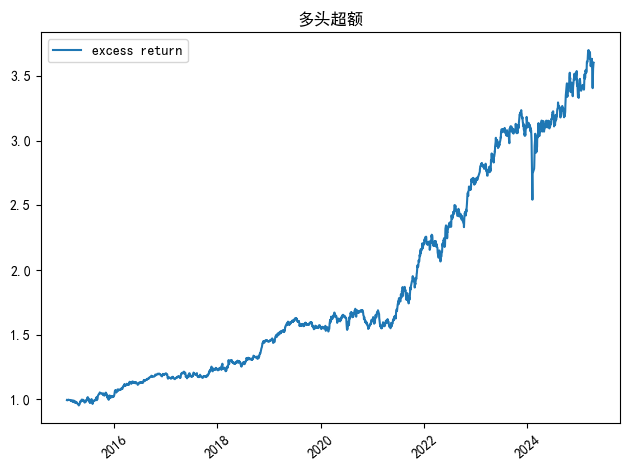

Rank IC: 5.04%
Rank ICIR: 0.34
t值: 3.82
年化收益率: 15.24%
年化波动率: 10.60%
信息比率: 1.44
最大回撤: 21.55%
Backtesting threshold=1.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0628 0.1550 -0.0997 0.1455 0.0829 0.1148 0.2736 0.2248 0.0864   
波动率     0.0889 0.0524  0.0745 0.0720 0.0624 0.1030 0.1462 0.1253 0.1022   
最大回撤   0.0561 0.0210  0.1261 0.0531 0.0541 0.0811 0.0981 0.0941 0.0908   
夏普率     0.7070 2.9569 -1.3380 2.0222 1.3285 1.1140 1.8715 1.7934 0.8459   
收益回撤比 1.1193 7.3857 -0.7905 2.7393 1.5307 1.4150 2.7894 2.3888 0.9516   
半波       0.0524 0.0260  0.0504 0.0411 0.0353 0.0578 0.0779 0.0623 0.0531   
半夏普     1.2000 5.9653 -1.9785 3.5378 2.3446 1.9852 3.5106 3.6079 1.6289   

              2024   2025   mean  
年化超额   -0.0050 0.2920 0.1212  
波动率      0.2038 0.1585 0.1081  
最大回

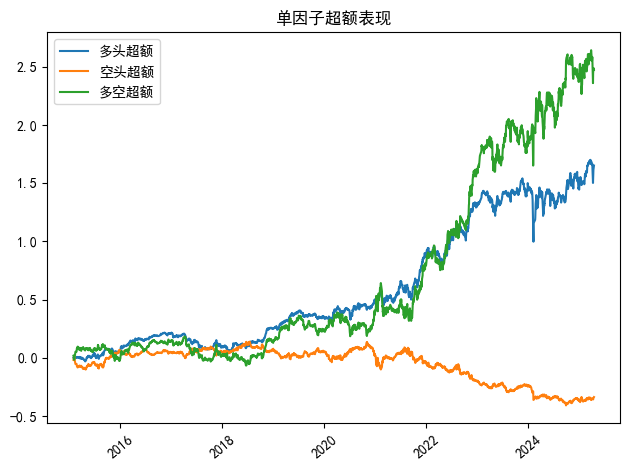

平均单边换手：0.591
年化交易成本:0.022 (未在超额中扣除)


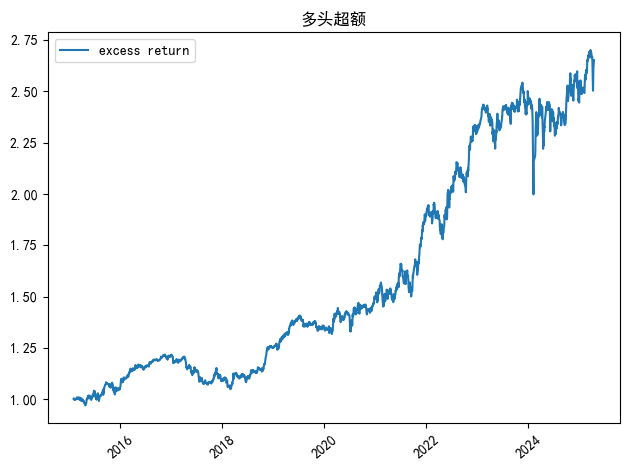

Rank IC: 3.92%
Rank ICIR: 0.26
t值: 2.90
年化收益率: 12.12%
年化波动率: 10.81%
信息比率: 1.12
最大回撤: 21.55%
Backtesting threshold=2.00% ...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0570 0.1282 -0.1291 0.1430 0.1021 0.0613 0.2736 0.2255 0.0503   
波动率     0.0895 0.0545  0.0769 0.0719 0.0627 0.1042 0.1462 0.1247 0.1032   
最大回撤   0.0591 0.0373  0.1480 0.0528 0.0541 0.1031 0.0981 0.0941 0.1232   
夏普率     0.6363 2.3526 -1.6779 1.9887 1.6281 0.5879 1.8715 1.8088 0.4869   
收益回撤比 0.9633 3.4392 -0.8720 2.7091 1.8862 0.5945 2.7894 2.3962 0.4079   
半波       0.0527 0.0291  0.0488 0.0412 0.0346 0.0584 0.0779 0.0625 0.0554   
半夏普     1.0809 4.4041 -2.6428 3.4722 2.9474 1.0499 3.5106 3.6082 0.9073   

             2024   2025   mean  
年化超额   0.0211 0.3149 0.1134  
波动率     0.2011 0.1939 0.1117  
最大回撤  

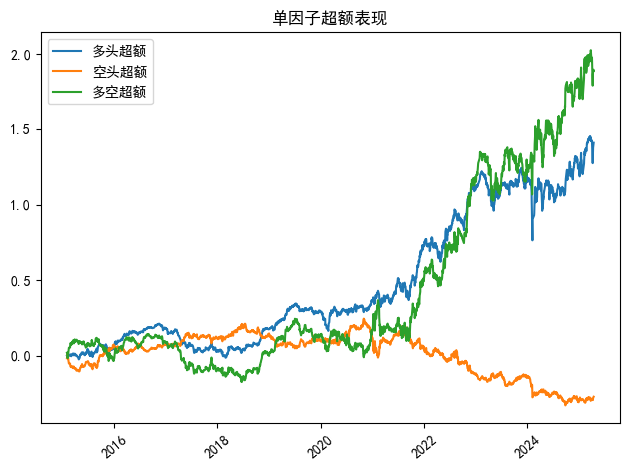

平均单边换手：0.568
年化交易成本:0.021 (未在超额中扣除)


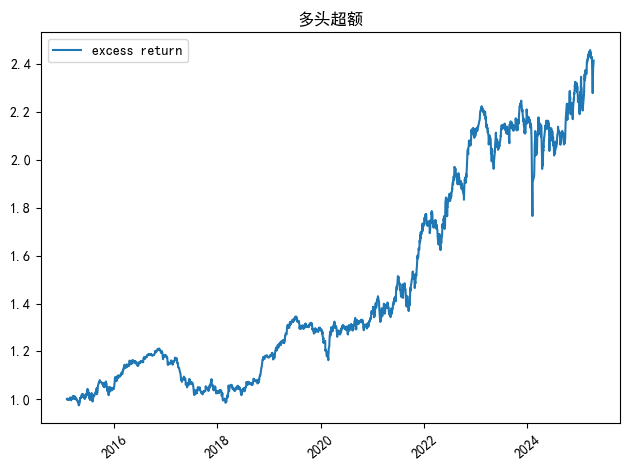

Rank IC: 4.03%
Rank ICIR: 0.27
t值: 2.99
年化收益率: 11.34%
年化波动率: 11.17%
信息比率: 1.02
最大回撤: 21.55%


In [12]:
thresholds = [-0.06,-0.05, -0.04,-0.03, -0.02,-0.01, 0, 0.01, 0.02]
results = {}

for threshold in thresholds:
    # 生成切分信号
    # risk-on: mkt_holding_ret > threshold，risk-off: <= threshold
    sign_mkt = np.where(mkt_holding_ret > threshold, 1, -1)
    sign_mkt = pd.Series(sign_mkt, index=mkt_holding_ret.index)
    # 对齐index
    sign_mkt = sign_mkt.reindex(holding_ret_copy.index)
    # 生成调整后的因子
    holding_ret_adj = holding_ret_copy.mul(sign_mkt, axis=0)
    
    # 回测
    print(f"Backtesting threshold={threshold:.2%} ...")
    res = config.backtest_stand(holding_ret_adj.loc['2015':], top=300, fre='month', stock_pool='888888')
    # Rank IC
    rank_ic = res['ic']['ic'].mean()
    # Rank ICIR
    rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
    # t值
    t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
    perf = res['多空表现']['多头表现']  
    annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
    annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
    info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
    #win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
    max_drawdown = perf.loc['最大回撤', 'mean']
    sharpe_ratio = annual_return / annual_vol
    print(f"Rank IC: {rank_ic:.2%}")
    print(f"Rank ICIR: {rank_icir:.2f}")
    print(f"t值: {t_value:.2f}")
    print(f"年化收益率: {annual_return:.2%}")
    print(f"年化波动率: {annual_vol:.2%}")
    print(f"信息比率: {info_ratio:.2f}")
    print(f"最大回撤: {max_drawdown:.2%}")
    results[threshold] = res

## 4.2 市场赚钱效应的切分频率

Backtesting freq: week...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-06-29 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-13 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-07-27 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-08-10 极端市场，不调仓
2015-08-24 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-14 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
2025-04-07 极端市场，不调仓
多头超额:
              2015    2016    2017   2018   2019   2020   2021   2022   2023  \
年化超额   -0.0150  0.3035 -0.0800 0.2741 0.0421 0.1362 0.1128 0.2043 0.0805   
波动率      0.1224  0.0539  0.0733 0.0758 0.0710 0.1049 0.1383 0.1358 0.1076   
最大回撤    0.1825  0.0176  0.1149 0.0463 0.0708 0.0632 0.1329 0.1347 0.0772   
夏普率     -0.1225  5.6312 -1.0915 3.6169 0.5926 1.2975 0.8157 1.5037 0.7476   
收益回撤比 -0.0822 17.2513 -0.6967 5.9254 0.5945 2.1529 0.8490 1.5159 1.0426   
半波        0.0715  0.0232  0.0466 0.0413 0.0445 0.0655 0.0785 0.0711 0.0571   
半夏普     -0.2098 13.0838 -1.7167 6.6411 0.

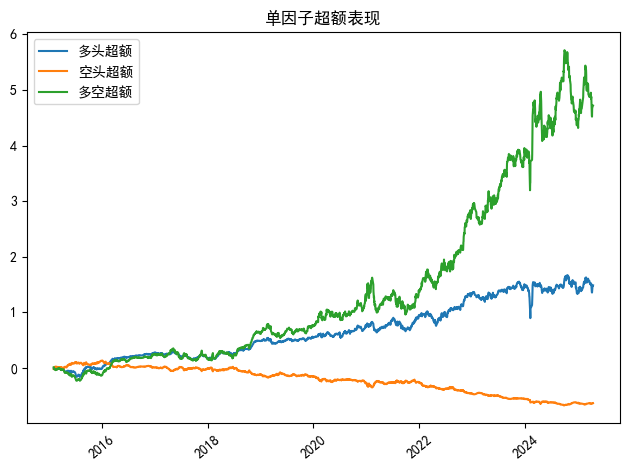

平均单边换手：0.347
年化交易成本:0.075 (未在超额中扣除)


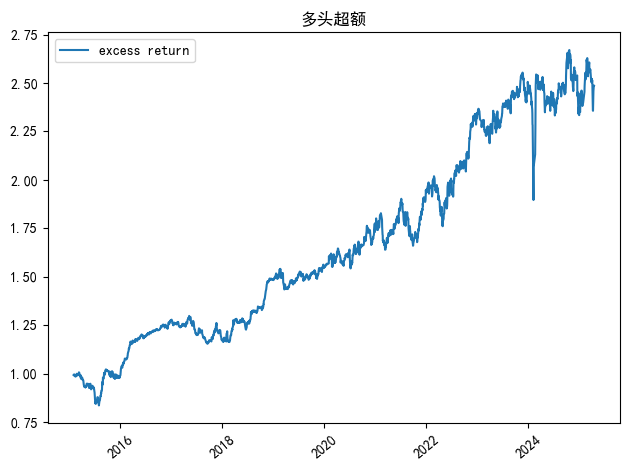

Rank IC: 2.41%
Rank ICIR: 0.15
t值: 3.59
年化收益率: 11.23%
年化波动率: 11.73%
信息比率: 0.96
最大回撤: 26.93%
Backtesting freq: du-week...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-06-19 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-07-06 极端市场，不调仓
2015-07-20 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2015-09-14 极端市场，不调仓
2016-01-04 极端市场，不调仓
2016-01-11 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015    2016    2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0175  0.2570 -0.0162 0.2766 0.0070 0.1118 0.3165 0.2814 0.1675   
波动率     0.1123  0.0528  0.0706 0.0753 0.0687 0.1048 0.1472 0.1313 0.1095   
最大回撤   0.1119  0.0208  0.0629 0.0490 0.0593 0.0739 0.1030 0.1227 0.0622   
夏普率     0.1554  4.8725 -0.2289 3.6732 0.1021 1.0666 2.1505 2.1429 1.5297   
收益回撤比 0.1561 12.3630 -0.2568 5.6432 0.1183 1.5122 3.0738 2.2932 2.6944   
半波       0.0646  0.0247  0.0425 0.0406 0.0441 0.0651 0.0794 0.0646 0.0555   
半夏普     0.2704 10.3981 -0.3800 6.8092 0.1590 1.7162 3.9870 4.3562 3.0197 

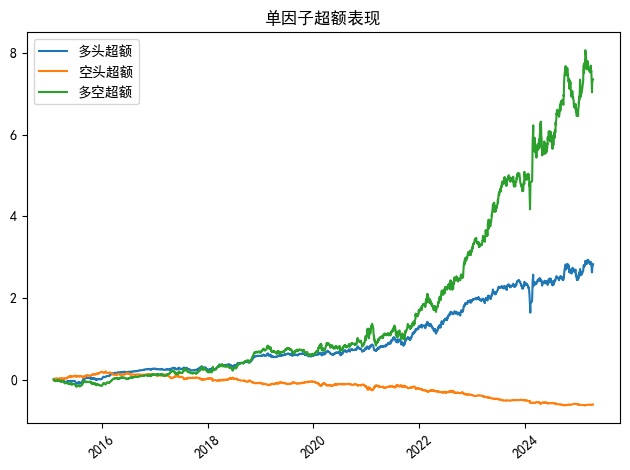

平均单边换手：0.413
年化交易成本:0.05 (未在超额中扣除)


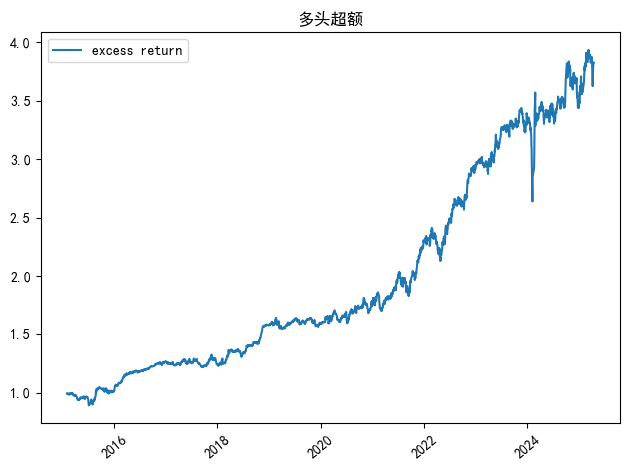

Rank IC: 3.13%
Rank ICIR: 0.20
t值: 3.82
年化收益率: 17.40%
年化波动率: 11.67%
信息比率: 1.49
最大回撤: 24.27%
Backtesting freq: month...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019   2020   2021   2022   2023  \
年化超额   0.0305 0.1716 0.0300 0.1804 0.0829 0.0337 0.3788 0.2248 0.1959   
波动率     0.0882 0.0527 0.0669 0.0733 0.0624 0.1036 0.1455 0.1253 0.0968   
最大回撤   0.0553 0.0210 0.0436 0.0464 0.0541 0.0954 0.0855 0.0941 0.0626   
夏普率     0.3453 3.2580 0.4494 2.4629 1.3285 0.3255 2.6045 1.7934 2.0229   
收益回撤比 0.5515 8.1812 0.6888 3.8853 1.5307 0.3535 4.4324 2.3888 3.1274   
半波       0.0527 0.0262 0.0423 0.0410 0.0353 0.0597 0.0763 0.0623 0.0445   
半夏普     0.5779 6.5562 0.7098 4.3988 2.3446 0.5649 4.9663 3.6079 4.4007   

             2024   2025   mean  
年化超额   0.0678 0.2801 0.1524  
波动率     0.1882 0.1634 0.1060  
最大回撤   0.2155 0.081

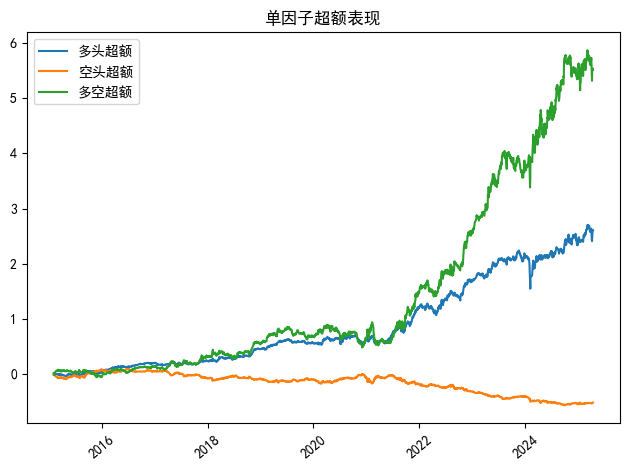

平均单边换手：0.591
年化交易成本:0.022 (未在超额中扣除)


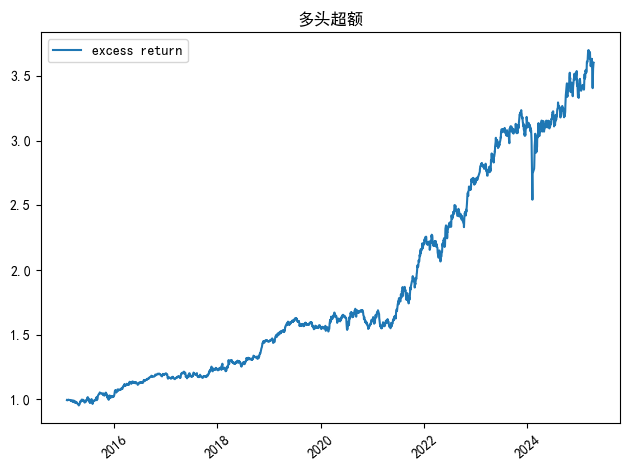

Rank IC: 5.04%
Rank ICIR: 0.34
t值: 3.82
年化收益率: 15.24%
年化波动率: 10.60%
信息比率: 1.44
最大回撤: 21.55%


In [9]:
results2 = {}
freq = ['week','du-week','month']
for freq in freq:
    print(f"Backtesting freq: {freq}...")
    res = config.backtest_stand(holding_ret_adj.loc['2015':], top=300, fre=freq, stock_pool='888888')
    results2[freq] = res
    # Rank IC
    rank_ic = res['ic']['ic'].mean()
    # Rank ICIR
    rank_icir = res['ic']['ic'].mean() / res['ic']['ic'].std()
    # t值
    t_value = res['ic']['ic'].mean() / (res['ic']['ic'].std() / np.sqrt(res['ic']['ic'].count()))
    perf = res['多空表现']['多头表现']  
    annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
    annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
    info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
    #win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
    max_drawdown = perf.loc['最大回撤', 'mean']
    sharpe_ratio = annual_return / annual_vol
    print(f"Rank IC: {rank_ic:.2%}")
    print(f"Rank ICIR: {rank_icir:.2f}")
    print(f"t值: {t_value:.2f}")
    print(f"年化收益率: {annual_return:.2%}")
    print(f"年化波动率: {annual_vol:.2%}")
    print(f"信息比率: {info_ratio:.2f}")
    print(f"最大回撤: {max_drawdown:.2%}")

## 5.1 筹码收益增强因子构建

In [9]:
holding_ret_enhanced = ret20_adj*(1-ret20_adj) +(1-ret20_adj)*holding_ret_adj
holding_ret_enhanced

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,000012,000014,000016,000017,000018,000019,000020,000021,000022,000023,...,920019,920029,920060,920066,920082,920088,920098,920099,920106,920108,920111,920116,920118,920128,b1,b2,b3,b4,b5,b6
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2009-01-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09,0.2654,0.2464,-0.9388,nan,0.3314,nan,-0.2947,0.3161,0.2100,0.2910,0.1858,0.2900,nan,0.2737,nan,-0.7938,0.0430,0.1629,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2025-04-10,0.2693,0.1720,-0.6295,nan,0.2956,nan,-0.7922,0.3213,0.2558,0.2256,0.1295,0.1956,nan,0.2796,nan,-1.0466,0.2074,0.0945,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2025-04-11,0.2703,0.1907,-0.4240,nan,0.1461,nan,-0.7267,0.3242,0.2932,0.2440,0.1366,0.2549,nan,0.2648,nan,-0.5124,0.2722,0.2760,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1551 0.1857 -0.1483 0.0732 0.0583 -0.0193 0.2613 0.1371 0.2001   
波动率     0.0786 0.0562  0.0501 0.0611 0.0576  0.0938 0.1177 0.1017 0.1009   
最大回撤   0.0573 0.0417  0.1586 0.0477 0.0577  0.0939 0.0521 0.0521 0.0561   
夏普率     1.9739 3.3057 -2.9607 1.1977 1.0118 -0.2060 2.2205 1.3482 1.9840   
收益回撤比 2.7063 4.4585 -0.9352 1.5357 1.0104 -0.2060 5.0147 2.6312 3.5678   
半波       0.0445 0.0274  0.0365 0.0382 0.0358  0.0556 0.0614 0.0540 0.0561   
半夏普     3.4888 6.7866 -4.0617 1.9178 1.6293 -0.3478 4.2545 2.5394 3.5667   

             2024   2025   mean  
年化超额   0.0466 0.0280 0.0889  
波动率     0.1735 0.1704 0.0965  
最大回撤   0.2016 0.0961 0.2016  
夏普率     0.2687 0.1641 0.9211  
收益回撤比 0.2313 0.2908 0.4410  
半波       0.1219 0.0642 0.0541  


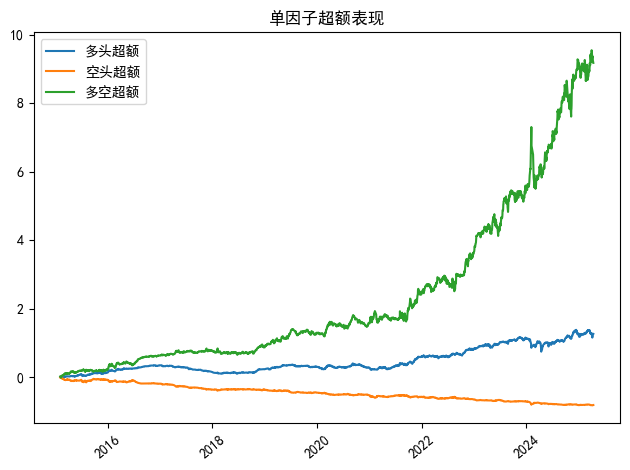

平均单边换手：0.739
年化交易成本:0.028 (未在超额中扣除)


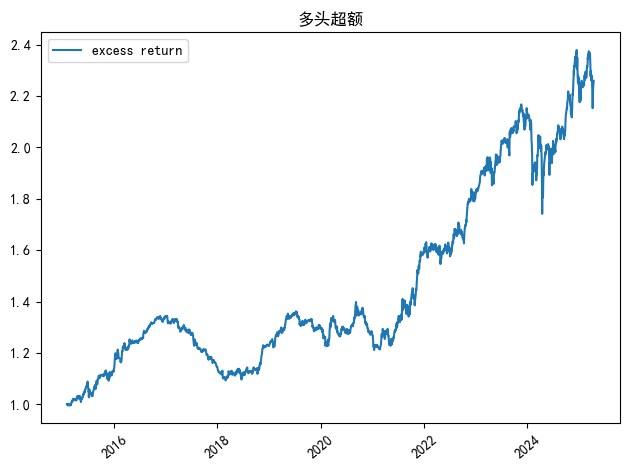

Rank IC: 4.86%
Rank ICIR: 0.41
t值: 4.59
年化收益率: 8.89%
年化波动率: 9.65%
信息比率: 0.92
最大回撤: 20.16%


In [19]:
res4=config.backtest_stand(holding_ret_enhanced.loc['2015':],top=300,fre='month',stock_pool='888888')
# Rank IC
rank_ic = res4['ic']['ic'].mean()
# Rank ICIR
rank_icir = res4['ic']['ic'].mean() / res4['ic']['ic'].std()
# t值
t_value = res4['ic']['ic'].mean() / (res4['ic']['ic'].std() / np.sqrt(res4['ic']['ic'].count()))
perf = res4['多空表现']['多头表现']  
annual_return = perf.loc['年化超额', 'mean']  # 年化收益率
annual_vol = perf.loc['波动率', 'mean']      # 年化波动率
info_ratio = perf.loc['信息比率', 'mean'] if '信息比率' in perf.index else annual_return / annual_vol
#win_rate = perf.loc['胜率', 'mean'] if '胜率' in perf.index else perf.loc['正月数', 'mean'] / perf.loc['总月数', 'mean']
max_drawdown = perf.loc['最大回撤', 'mean']
sharpe_ratio = annual_return / annual_vol
print(f"Rank IC: {rank_ic:.2%}")
print(f"Rank ICIR: {rank_icir:.2f}")
print(f"t值: {t_value:.2f}")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"信息比率: {info_ratio:.2f}")
#print(f"夏普比率: {sharpe_ratio:.2f}")
#print(f"月度胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")


## 5.2 合成因子的分域表现

不同股票池回测结果

正在回测 沪深300 (000300)...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017    2018   2019    2020   2021    2022   2023  \
年化超额   0.1568 0.0306 -0.0267 -0.0354 0.0332 -0.0471 0.1328 -0.0110 0.1029   
波动率     0.1182 0.0513  0.0562  0.0706 0.0742  0.0574 0.0743  0.0864 0.0743   
最大回撤   0.1030 0.0349  0.0883  0.1092 0.0543  0.0693 0.0385  0.0970 0.0480   
夏普率     1.3269 0.5964 -0.4758 -0.5008 0.4474 -0.8208 1.7877 -0.1276 1.3847   
收益回撤比 1.5231 0.8763 -0.3029 -0.3237 0.6120 -0.6791 3.4518 -0.1137 2.1409   
半波       0.0681 0.0296  0.0366  0.0449 0.0426  0.0347 0.0409  0.0509 0.0388   
半夏普     2.3037 1.0332 -0.7309 -0.7880 0.7797 -1.3572 3.2483 -0.2163 2.6520   

             2024   2025   mean  
年化超额   0.1110 0.0038 0.0410  
波动率     0.1276 0.0747 0.0786  
最大回撤   0.0927 0.0565 0.1092  
夏普率     0.8705 0.0513 0.5213  
收益回撤比 1.197

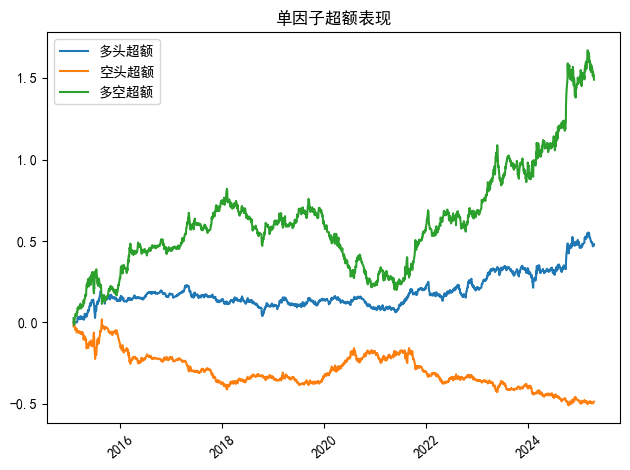

平均单边换手：0.558
年化交易成本:0.021 (未在超额中扣除)


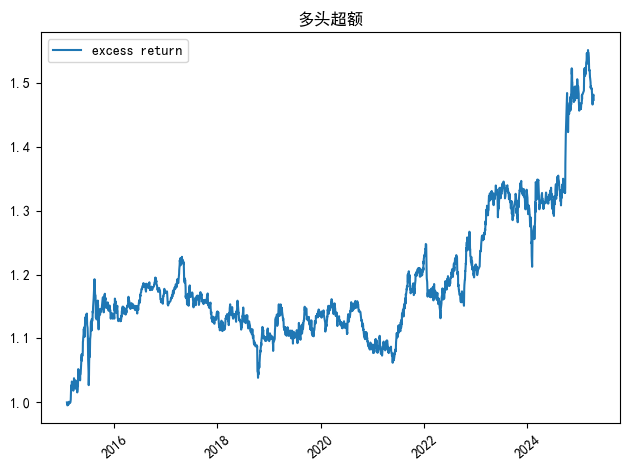

沪深300 回测完成
   年化超额收益: 4.10%
   信息比率: 0.52
   Rank IC: 0.017

正在回测 中证500 (000905)...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.0864 0.1562 -0.0030 0.0074 0.0164 -0.0333 0.0662 0.0333 0.0838   
波动率     0.0632 0.0389  0.0303 0.0316 0.0295  0.0416 0.0503 0.0464 0.0338   
最大回撤   0.0359 0.0287  0.0383 0.0331 0.0188  0.0426 0.0294 0.0376 0.0151   
夏普率     1.3681 4.0118 -0.0991 0.2334 0.5577 -0.8001 1.3167 0.7163 2.4823   
收益回撤比 2.4082 5.4496 -0.0785 0.2230 0.8741 -0.7809 2.2515 0.8856 5.5474   
半波       0.0317 0.0167  0.0186 0.0196 0.0177  0.0244 0.0253 0.0245 0.0165   
半夏普     2.7297 9.3616 -0.1614 0.3763 0.9289 -1.3650 2.6180 1.3589 5.0744   

             2024   2025   mean  
年化超额   0.0756 0.0898 0.0526  
波动率     0.0524 0.0423 0.0418  
最大回撤   0.0438 0.0135 0.0438  
夏普率     

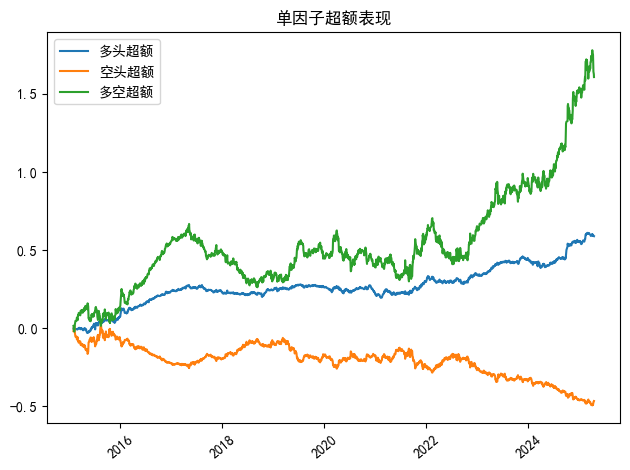

平均单边换手：0.465
年化交易成本:0.017 (未在超额中扣除)


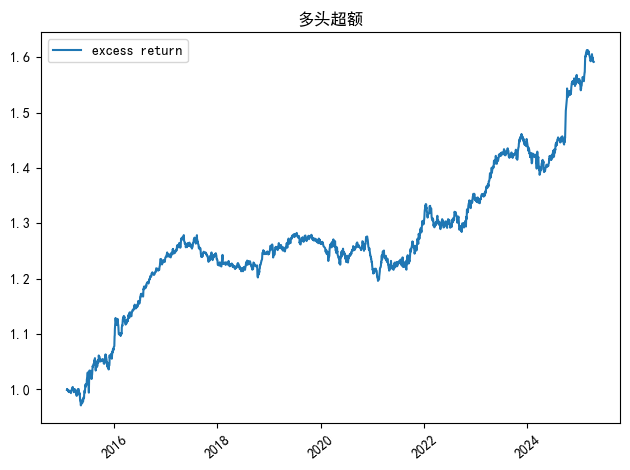

中证500 回测完成
   年化超额收益: 5.26%
   信息比率: 1.26
   Rank IC: 0.013

正在回测 中证1000 (1000)...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016   2017   2018   2019    2020   2021   2022   2023  \
年化超额   0.1064 0.0637 0.0439 0.0457 0.0573 -0.0339 0.1120 0.0410 0.1261   
波动率     0.0624 0.0374 0.0306 0.0332 0.0321  0.0415 0.0507 0.0682 0.0401   
最大回撤   0.0447 0.0396 0.0241 0.0246 0.0139  0.0613 0.0317 0.0584 0.0152   
夏普率     1.7045 1.7049 1.4325 1.3782 1.7845 -0.8176 2.2086 0.6007 3.1482   
收益回撤比 2.3777 1.6087 1.8201 1.8613 4.1150 -0.5533 3.5386 0.7014 8.3047   
半波       0.0315 0.0207 0.0178 0.0212 0.0169  0.0247 0.0267 0.0396 0.0198   
半夏普     3.3809 3.0729 2.4687 2.1590 3.3942 -1.3731 4.1886 1.0339 6.3770   

             2024   2025   mean  
年化超额   0.1113 0.0346 0.0644  
波动率     0.0559 0.0390 0.0447  
最大回撤   0.0559 0.0227 0.0613  
夏普率     1.9889 0.

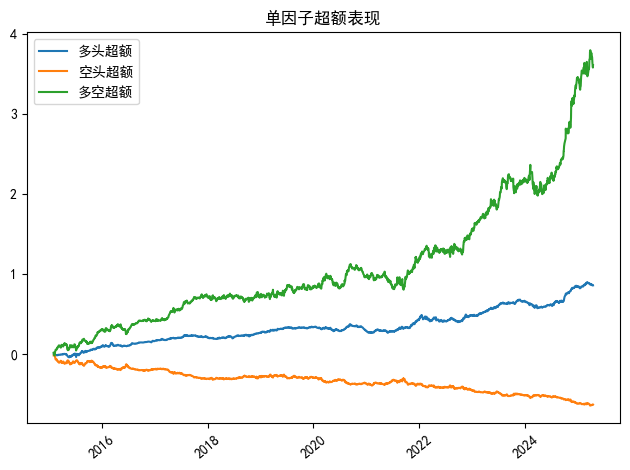

平均单边换手：0.586
年化交易成本:0.022 (未在超额中扣除)


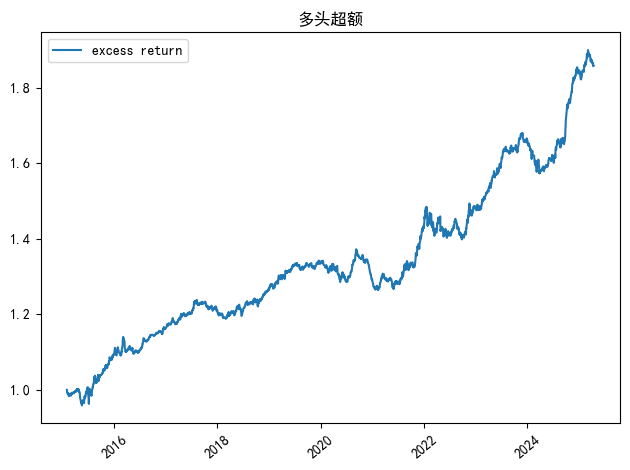

中证1000 回测完成
   年化超额收益: 6.44%
   信息比率: 1.44
   Rank IC: 0.031

正在回测 全A股 (888888)...
load data locally from 2009-01-05 to 2025-04-15
2015-06-01 极端市场，不调仓
2015-07-01 极端市场，不调仓
2015-08-03 极端市场，不调仓
2015-09-01 极端市场，不调仓
2016-01-04 极端市场，不调仓
2020-02-03 极端市场，不调仓
多头超额:
             2015   2016    2017   2018   2019    2020   2021    2022   2023  \
年化超额   0.1551 0.1598 -0.1037 0.0491 0.0683 -0.0750 0.0261 -0.0088 0.1472   
波动率     0.0732 0.0460  0.0361 0.0476 0.0613  0.0721 0.0947  0.1083 0.0864   
最大回撤   0.0565 0.0307  0.1164 0.0475 0.0371  0.1001 0.1559  0.1029 0.0472   
夏普率     2.1199 3.4762 -2.8720 1.0316 1.1148 -1.0395 0.2760 -0.0813 1.7038   
收益回撤比 2.7438 5.2143 -0.8902 1.0337 1.8411 -0.7490 0.1677 -0.0856 3.1197   
半波       0.0409 0.0231  0.0256 0.0285 0.0361  0.0457 0.0576  0.0631 0.0442   
半夏普     3.7881 6.9138 -4.0422 1.7266 1.8897 -1.6412 0.4542 -0.1396 3.3341   

             2024    2025   mean  
年化超额   0.1026 -0.0394 0.0438  
波动率     0.2056  0.1820 0.0921  
最大回撤   0.2858  0.1258 0.2858

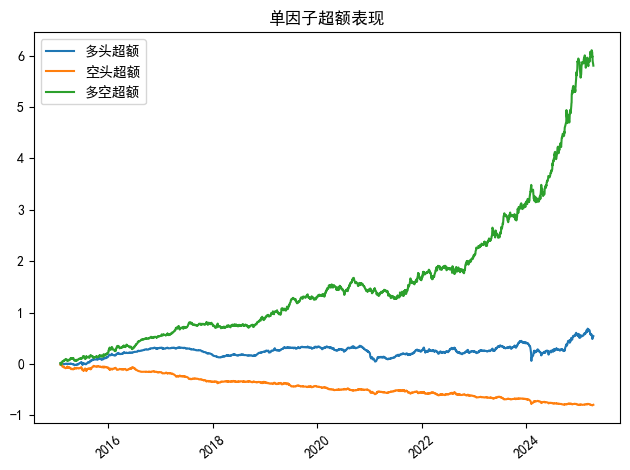

平均单边换手：0.754
年化交易成本:0.029 (未在超额中扣除)


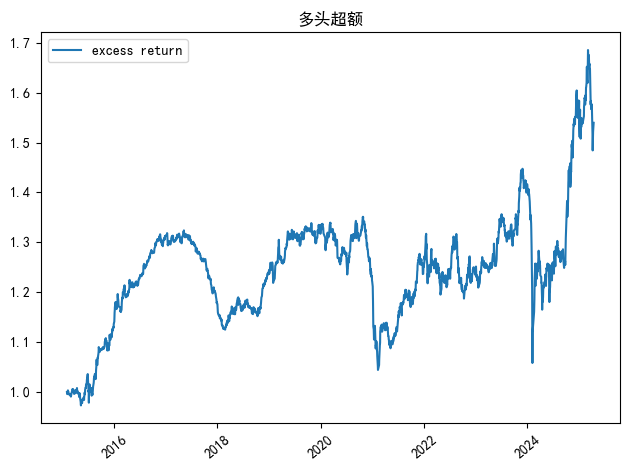

全A股 回测完成
   年化超额收益: 4.38%
   信息比率: 0.48
   Rank IC: 0.027

回测结果汇总
     股票池    代码  年化超额收益  年化波动率  信息比率  最大回撤  Rank IC  \
0   沪深300  000300        0.0410      0.0786    0.5213    0.1092   0.0169   
1   中证500  000905        0.0526      0.0418    1.2575    0.0438   0.0131   
2  中证1000    1000        0.0644      0.0447    1.4417    0.0613   0.0306   
3     全A股  888888        0.0438      0.0921    0.4751    0.2858   0.0268   

    ICIR  
0 0.1298  
1 0.1364  
2 0.3673  
3 0.4049  


In [10]:
# 不同股票池回测代码
import pandas as pd
import numpy as np

# 指数池与benchmark、top的对应关系
pool_benchmark_top_map = {
    '000300': {'benchmark': 'b1', 'top': 100},   # 沪深300
    '000905': {'benchmark': 'b2', 'top': 300},   # 中证500
    '1000':   {'benchmark': 'b4', 'top': 300},   # 中证1000
    '1800':   {'benchmark': 'b3', 'top': 500},   # 800+1000
    '2000':   {'benchmark': 'b6', 'top': 500},   # 国证2000
    '888888': {'benchmark': 'b2', 'top': 300},   # 全A，默认
}

def get_benchmark_and_top(pool_code):
    """获取对应的基准和选股数量"""
    if pool_code.startswith('TOP'):
        return 'b2', int(pool_code[3:]) 
    if pool_code.startswith('TPCT'):
        return 'b2', None               
    return (
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['benchmark'],
        pool_benchmark_top_map.get(pool_code, {'benchmark': 'b2', 'top': 300})['top']
    )

# 股票池配置
pools_config = [
    ('000300', '沪深300'),
    ('000905', '中证500'), 
    ('1000', '中证1000'),
    ('888888', '全A股')  # 添加全A作为对比
]


results = []  
detailed_results = []  

print("="*60)
print("不同股票池回测结果")
print("="*60)

for pool_code, pool_name in pools_config:
    print(f"\n正在回测 {pool_name} ({pool_code})...")
    
    # 获取对应的基准和选股数量
    benchmark, top = get_benchmark_and_top(pool_code)
    
    # 执行回测
    res = config.backtest_stand(
        holding_ret_enhanced.loc['2015':], 
        benchmark=benchmark,
        stock_pool=pool_code,
        barra_neutral=True,
        fre='month',
        top=top
    )
    
    # 提取关键指标
    performance_metrics = {
        '股票池': pool_name,  # 添加股票池名称
        '代码': pool_code,    # 添加代码
        '年化超额收益': res['多空表现']['多头表现'].loc['年化超额', 'mean'],
        '年化波动率': res['多空表现']['多头表现'].loc['波动率', 'mean'],
        '信息比率': res['多空表现']['多头表现'].loc['年化超额', 'mean'] / res['多空表现']['多头表现'].loc['波动率', 'mean'],
        '最大回撤': res['多空表现']['多头表现'].loc['最大回撤', 'mean'],
        'Rank IC': res['ic']['ic'].mean(),
        'ICIR': res['ic']['ic'].mean() / res['ic']['ic'].std()
    }
    
    # 存储结果 - 改为append到list
    results.append(performance_metrics)
    detailed_results.append((pool_name, res))  # 存储为tuple
    
    # 打印结果
    print(f"{pool_name} 回测完成")
    print(f"   年化超额收益: {performance_metrics['年化超额收益']:.2%}")
    print(f"   信息比率: {performance_metrics['信息比率']:.2f}")
    print(f"   Rank IC: {performance_metrics['Rank IC']:.3f}")

# 将results转换为DataFrame便于查看
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("回测结果汇总")
print("="*60)
print(results_df)